# Pipline

Теперь вы можете объединить все части кода в единый алгоритм:

1. Тензорное модальное разложение (TBMD):
* Выполнить Tucker-разложение тензора 𝑋 для получения тензора 𝐴.

2. Оптимальное размещение сенсоров:
* Применить тензорное QR-разложение к 𝐴 для получения матрицы 𝑃.

3. Формирование измерений:
* Сформировать измерения 𝑌 с использованием 𝑃 и 𝑋.

4. Восстановление вектора весов 𝑥:
* Применить тензорное компрессивное измерение для восстановления 𝑥.

5. Восстановление поля 𝑋:
* Использовать 𝑥 и 𝐴 для восстановления 𝑋

# Download packages

In [1]:
%pip install -U tensorly torch

Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [2]:
import numpy as np
import tensorly as tl
import math
import matplotlib.pyplot as plt


from PIL import Image
from pathlib import Path
from tensorly.decomposition import tucker
from tensorly import tenalg, tucker_to_tensor
from tensorly.tenalg import mode_dot
from typing import Set, Tuple, Union
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [3]:
tl.set_backend('numpy')

In [4]:
SEED = 42

tl.check_random_state(SEED)
np.random.seed(SEED)

# Download data

In [5]:
# Путь к данным
dataset_path = Path("data/ExtendedYaleB/GroupedDataBySubject")  # Путь к данным

# Считываем данные по субъектам
subject_images = defaultdict(list)
for subject_dir in dataset_path.iterdir():
    if subject_dir.is_dir():
        subject_id = subject_dir.name
        subject_images[subject_id] = list(subject_dir.glob("*.png"))

# Проверка на наличие данных
if not subject_images:
    raise ValueError("Данные для субъектов не найдены!")

# Функция для разбиения данных на train/test
def split_data_in_memory(subject_images, experiment_id, train_ratio=0.8):
    """
    Делит данные для каждого субъекта на тренировочный и тестовый наборы.
    Результаты возвращаются в виде словаря в памяти.
    """
    train_data = defaultdict(list)
    test_data = defaultdict(list)

    for subject, images in subject_images.items():
        # Разделение на train и test
        train_images, test_images = train_test_split(
            images, test_size=np.round(1-train_ratio, 1), random_state=experiment_id
        )
        train_data[subject].extend(train_images)
        test_data[subject].extend(test_images)

    return train_data, test_data

# Проведение 20 экспериментов с разными random_state
experiments_data = {}  # Хранение результатов всех экспериментов
for experiment_id in range(1, 21):
    train_data, test_data = split_data_in_memory(subject_images, experiment_id)
    experiments_data[experiment_id] = {"train": train_data, "test": test_data}

print("Все эксперименты успешно обработаны в памяти.")

Все эксперименты успешно обработаны в памяти.


In [6]:
# Обработка первого эксперимента
train_data = experiments_data[1]["train"]
test_data = experiments_data[1]["test"]

# Пример: подсчет количества изображений для каждого субъекта
for subject, images in train_data.items():
    print(f"Subject: {subject}, Train images: {len(images)}")

for subject, images in test_data.items():
    print(f"Subject: {subject}, Test images: {len(images)}")

# Пример: загрузка первого изображения для обработки
example_image_path = list(train_data["Subject_01"])[0]  # Получаем путь к изображению
with Image.open(example_image_path) as img:
    img_array = np.array(img)  # Преобразуем в numpy массив
    print("Размер изображения:", img_array.shape)

Subject: Subject_12, Train images: 48
Subject: Subject_15, Train images: 51
Subject: Subject_23, Train images: 52
Subject: Subject_24, Train images: 52
Subject: Subject_25, Train images: 52
Subject: Subject_22, Train images: 52
Subject: Subject_13, Train images: 48
Subject: Subject_31, Train images: 52
Subject: Subject_36, Train images: 52
Subject: Subject_09, Train images: 52
Subject: Subject_07, Train images: 52
Subject: Subject_38, Train images: 52
Subject: Subject_06, Train images: 52
Subject: Subject_39, Train images: 52
Subject: Subject_01, Train images: 52
Subject: Subject_37, Train images: 52
Subject: Subject_08, Train images: 52
Subject: Subject_30, Train images: 52
Subject: Subject_29, Train images: 52
Subject: Subject_16, Train images: 50
Subject: Subject_11, Train images: 48
Subject: Subject_18, Train images: 51
Subject: Subject_27, Train images: 52
Subject: Subject_20, Train images: 52
Subject: Subject_21, Train images: 52
Subject: Subject_19, Train images: 52
Subject: Sub

In [7]:
# Загрузка всех изображений для Subject_01 и создание тензора
subject_id = "Subject_01"  # Субъект для примера
image_paths = train_data[subject_id]  # Пути к изображениям для Subject_01

# Проверяем, что данные для Subject_01 существуют
if not image_paths:
    raise ValueError(f"Нет изображений для субъекта {subject_id} в тренировочных данных.")

# Сортируем изображения по имени, если необходимо (например, для временной последовательности)
image_paths = sorted(image_paths, key=lambda x: x.name)

# Инициализируем список для хранения изображений
image_slices = []

# Загрузка данных и перевод в float
def load_images_as_tensor(subject_images):
    """
    Загружает изображения для заданного субъекта и преобразует их в тензор float.
    """
    images = []
    for img_path in subject_images:
        with Image.open(img_path) as img:
            img_array = np.array(img.convert("L"), dtype=np.float32)  # Перевод в grayscale и float
            img_array /= 255.0  # Нормализация в диапазон [0, 1]
            images.append(img_array)
    return np.stack(images, axis=-1)  # Создаем тензор (H, W, T)

# Пример: обработка данных для одного субъекта
subject = "Subject_01"
tensor = load_images_as_tensor(train_data[subject])
print(f"Размеры исходного тензора для {subject}: {tensor.shape}")

Размеры исходного тензора для Subject_01: (42, 48, 52)


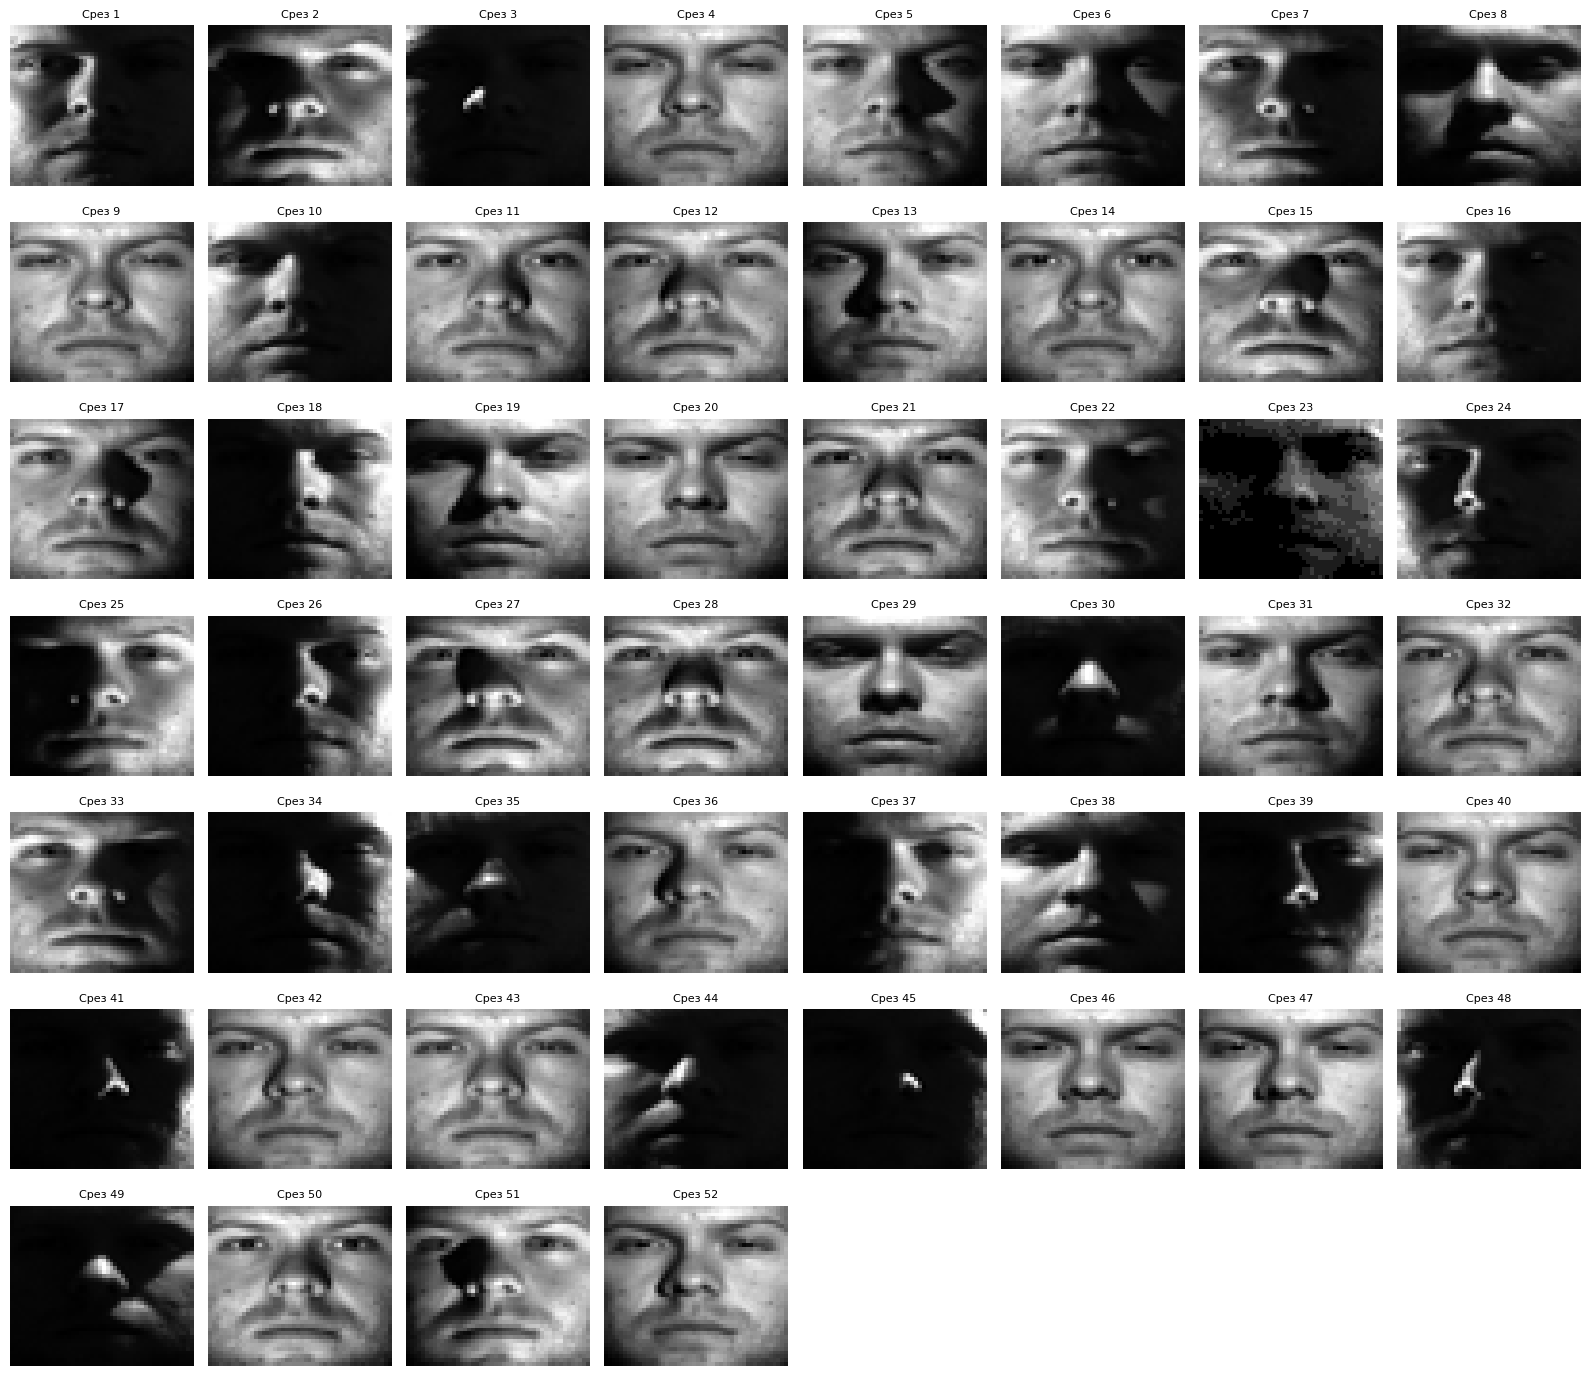

In [8]:
# Определяем количество изображений
num_images = tensor.shape[2]  # Количество срезов по третьей оси (временной)

# Рассчитываем количество строк и столбцов для субплотов
cols = 8  # Задаем фиксированное количество столбцов
rows = math.ceil(num_images / cols)  # Рассчитываем количество строк

# Визуализация всех изображений
plt.figure(figsize=(cols * 2, rows * 2))  # Увеличиваем размер графика пропорционально

for idx in range(num_images):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(tensor[:, :, idx], cmap="gray")
    plt.title(f"Срез {idx + 1}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
# Создаем словарь для хранения тензоров по субъектам
tensors_by_subject = {}

# Загружаем изображения для всех субъектов и создаем тензоры
for subject in train_data:
    tensor = load_images_as_tensor(train_data[subject])
    tensors_by_subject[subject] = tensor
    print(f"Subject {subject} tensor shape: {tensor.shape}")

# Проверяем минимальное количество изображений у субъектов
num_images = {subject: tensor.shape[-1] for subject, tensor in tensors_by_subject.items()}
min_images = min(num_images.values())
print(f"Минимальное количество изображений: {min_images}")

# Приведение тензоров к одинаковому размеру
for subject in tensors_by_subject:
    tensor = tensors_by_subject[subject]
    if tensor.shape[-1] > min_images:
        # Обрезаем лишние кадры
        tensors_by_subject[subject] = tensor[:, :, :min_images]
    elif tensor.shape[-1] < min_images:
        # Повторяем последние кадры для дополнения
        padding = min_images - tensor.shape[-1]
        last_frame = np.expand_dims(tensor[:, :, -1], axis=-1)  # Последний кадр
        padding_frames = np.repeat(last_frame, padding, axis=-1)
        tensors_by_subject[subject] = np.concatenate((tensor, padding_frames), axis=-1)

# Стекаем тензоры по субъектам вдоль новой оси
stacked_tensor = np.stack(list(tensors_by_subject.values()), axis=-1)
print(f"Stacked tensor shape: {stacked_tensor.shape}")

Subject Subject_12 tensor shape: (42, 48, 48)
Subject Subject_15 tensor shape: (42, 48, 51)
Subject Subject_23 tensor shape: (42, 48, 52)
Subject Subject_24 tensor shape: (42, 48, 52)
Subject Subject_25 tensor shape: (42, 48, 52)
Subject Subject_22 tensor shape: (42, 48, 52)
Subject Subject_13 tensor shape: (42, 48, 48)
Subject Subject_31 tensor shape: (42, 48, 52)
Subject Subject_36 tensor shape: (42, 48, 52)
Subject Subject_09 tensor shape: (42, 48, 52)
Subject Subject_07 tensor shape: (42, 48, 52)
Subject Subject_38 tensor shape: (42, 48, 52)
Subject Subject_06 tensor shape: (42, 48, 52)
Subject Subject_39 tensor shape: (42, 48, 52)
Subject Subject_01 tensor shape: (42, 48, 52)
Subject Subject_37 tensor shape: (42, 48, 52)
Subject Subject_08 tensor shape: (42, 48, 52)
Subject Subject_30 tensor shape: (42, 48, 52)
Subject Subject_29 tensor shape: (42, 48, 52)
Subject Subject_16 tensor shape: (42, 48, 50)
Subject Subject_11 tensor shape: (42, 48, 48)
Subject Subject_18 tensor shape: (

# Applying TBMD to each tensor

Применяем тензорное модальное разложение (TBMD), в данном случае Tucker разложение, к каждому тензору, получая модальные тензоры 𝑀1, 𝑀2, …, 𝑀𝐷.

In [10]:
from TBMD.TensorHOSVD import TuckerDecomposer

In [11]:
# Создаем случайный 3D-тензор размером 10x10x10
tensor = tensors_by_subject['Subject_34']

# Инициализируем объект TuckerDecomposer с заданными ранками
decomposer = TuckerDecomposer(tensor, random_state=SEED)

# Выполняем декомпозицию
decomposer.decompose()

cores = decomposer.get_cores()

factors = decomposer.get_factors()

In [127]:
# # Параметры
# epsilon = 1e-2  # Порог сходимости

# # Словари для хранения ядер и факторов
# cores_by_subject = {}
# factors_by_subject = {}
# reconstruction_errors = {}

# # Рассчет точности восстановления и отображение примеров
# for subject, tensor in tensors_by_subject.items():
#     # Определение рангов для Tucker-декомпозиции
#     ranks = [min(tensor.shape)] * len(tensor.shape)
    
#     # Выполнение Tucker-декомпозиции
#     core, factors = tucker(tensor, rank=ranks, tol=epsilon, random_state=SEED)
#     reconstructed_tensor = tucker_to_tensor((core, factors))
    
#     # Подсчет ошибки восстановления
#     reconstruction_error = np.linalg.norm(tensor - reconstructed_tensor) / np.linalg.norm(tensor)
#     reconstruction_errors[subject] = reconstruction_error
    
#     # Сохранение ядра и факторов
#     cores_by_subject[subject] = core
#     factors_by_subject[subject] = factors
    
#     # Вывод формы ядра и факторов
#     print(f"Subject {subject}: Core shape {core.shape}")
#     print(f"Subject {subject}: Factors shapes {[f.shape for f in factors]}")
#     print(f"Subject {subject}: Reconstruction error: {reconstruction_error:.5f}")
    
#     # Визуализация примера для текущего субъекта
#     plt.figure(figsize=(12, 6))

#     # Исходное изображение
#     plt.subplot(1, 2, 1)
#     plt.imshow(tensor[:, :, tensor.shape[-1] // 2], cmap="gray")
#     plt.title(f"Исходное изображение (Subject {subject})")
#     plt.axis("off")

#     # Восстановленное изображение
#     plt.subplot(1, 2, 2)
#     plt.imshow(reconstructed_tensor[:, :, tensor.shape[-1] // 2], cmap="gray")
#     plt.title(f"Восстановленное изображение (Subject {subject})")
#     plt.axis("off")
    
#     plt.show()

# # Вывод общих ошибок восстановления
# print("\nСводка ошибок восстановления:")
# for subject, error in reconstruction_errors.items():
#     print(f"Subject {subject}: Reconstruction error: {error:.5f}")

# Construction of the joint modal tensor 𝐴


Стекуем модальные тензоры 𝑀1, 𝑀2, …, 𝑀𝐷 по третьему измерению (или создаем объединенный тензор), получая тензор 𝐴.

In [128]:
# # Step 1: Extract factor matrices and rank information from Tucker decomposition
# # A_hat, B_hat, and C_hat represent the factor matrices for modes 1, 2, and 3, respectively.
# A_hat, B_hat, C_hat = factors  # Decomposed factor matrices
# R = core.shape[2]  # Number of temporal modes (rank along the third dimension)

# # Step 2: Compute time-irrelevant modal matrices using TensorLy's mode_dot
# # Initialize an empty list to store the modal matrices for each temporal mode
# M_list = []

# for n in range(R):
#     # Slice the core tensor along the third dimension to get the nth mode's core slice
#     G_slice = core[:, :, n]  # Extract the (I x J) core slice for the nth temporal mode

#     # Compute the modal matrix M_n for the nth mode using mode_dot
#     # Apply mode_dot for the first mode with A_hat
#     M_n = mode_dot(G_slice, A_hat, mode=0)  # Multiply along the 0th mode

#     # Apply mode_dot for the second mode with B_hat
#     M_n = mode_dot(M_n, B_hat, mode=1)  # Multiply along the 1st mode

#     # Append the computed modal matrix to the list
#     M_list.append(M_n)

# # Step 3: Stack the computed modal matrices to form the final tensor
# # The final tensor A_tensor will have dimensions (I, J, R), where R is the number of temporal modes
# A_tensor = tl.stack(M_list, axis=-1)

# # Step 4: Validate the dimensions of the resulting tensor
# print(f"Размер тензора временно-нечувствительных мод: {A_tensor.shape}")


In [129]:
# # Словарь для хранения временно-нечувствительных модальных тензоров
# M_tensors = {}

# # Итерация по всем субъектам с использованием данных из cores_by_subject и factors_by_subject
# for subject in cores.keys():
#     # Получаем ядро и матрицы факторов для текущего субъекта
#     core = cores[subject]
#     factor = factors[subject]
    
#     # Извлечение матриц факторов
#     A_hat, B_hat, C_hat = factor
#     R = core.shape[2]  # Число временных мод (ранг по третьему измерению)
    
#     # Список для хранения модальных матриц
#     M_list = []
    
#     for n in range(R):
#         # Срез ядра по третьему измерению
#         G_slice = core[:, :, n]
        
#         # Вычисление модальной матрицы M_n
#         # M_n = A * G_slice * B^T
#         M_n = mode_dot(G_slice, A_hat, mode=0)  # Умножение по 0-й размерности
#         M_n = mode_dot(M_n, B_hat, mode=1)  # Умножение по 1-й размерности
        
#         # Добавление модальной матрицы в список
#         M_list.append(M_n)
    
#     # Формирование финального тензора
#     modal_tensor = tl.stack(M_list, axis=-1)  # Размерность (I, J, R)
    
#     # Сохранение тензора для текущего субъекта
#     M_tensors[subject] = modal_tensor
    
#     # Вывод размера тензора
#     print(f"Subject {subject}: Размер тензора временно-нечувствительных мод: {modal_tensor.shape}")


In [12]:
# # Словарь для хранения временно-нечувствительных модальных тензоров
# M_tensors = {}

# # Итерация по всем субъектам
# for subject in cores.keys():
#     # Получаем ядро и матрицы факторов для текущего субъекта
#     core = cores[subject]
#     factor = factors[subject]
    
#     # Извлечение матриц факторов
#     A_hat, B_hat, C_hat = factor
#     R = core.shape[2]  # Число временных мод (ранг по третьему измерению)
    
#     # Список для хранения модальных матриц
#     M_list = []
    
#     for n in range(R):
#         # Срез ядра по третьему измерению
#         G_slice = core[:, :, n]
        
#         # Вычисление модальной матрицы M_n
#         # M_n = A_hat @ G_slice @ B_hat^T
#         M_n = A_hat @ G_slice @ B_hat.T
        
#         # Добавление модальной матрицы в список
#         M_list.append(M_n)
    
#     # Формирование финального тензора
#     modal_tensor = np.stack(M_list, axis=-1)  # Размерность (I, J, R)
    
#     # Сохранение тензора для текущего субъекта
#     M_tensors[subject] = modal_tensor
    
#     # Вывод размера тензора
#     print(f"Subject {subject}: Размер тензора временно-нечувствительных мод: {modal_tensor.shape}")


In [131]:
# # Инициализируем пустой список для хранения всех мод
# all_modes = []

# # Итерация по всем субъектам
# for subject, modal_tensor in M_tensors.items():
#     # Убедимся, что modal_tensor является тензором TensorLy
#     modal_tensor = tl.tensor(modal_tensor)  # Преобразуем в TensorLy, если это NumPy
    
#     # Извлекаем размерности
#     I, J, R = modal_tensor.shape
#     for r in range(R):
#         # Добавляем каждую моду в список
#         all_modes.append(modal_tensor[:, :, r])  # Размерность (I, J)

# # Объединяем все моды вдоль третьего измерения
# # Используем tl.stack, чтобы результат остался типом TensorLy
# A_tensor = tl.stack(all_modes, axis=-1)  # Размерность (I, J, W), где W = сумма всех R

# # Проверяем размерность результирующего тензора
# print(f"Final stacked tensor shape (A): {A_tensor.shape}")


In [13]:
# # Инициализируем пустой список для хранения всех мод
# all_modes = []

# # Итерация по всем субъектам
# for subject, modal_tensor in M_tensors.items():
#     # Извлекаем размерности
#     I, J, R = modal_tensor.shape
#     for r in range(R):
#         # Добавляем каждую моду в список
#         all_modes.append(modal_tensor[:, :, r])  # Размерность (I, J)

# # Объединяем все моды вдоль третьего измерения
# A_tensor = tl.stack(all_modes, axis=-1)  # Размерность (I, J, W), где W = сумма всех R

# # Проверяем размерность результирующего тензора
# print(f"Final stacked tensor shape (A): {A_tensor.shape}")

In [14]:
# Универсальный словарь для хранения временно-нечувствительных модальных тензоров
M_tensors = {}

# Проверяем, является ли cores словарем или numpy array
if isinstance(cores, dict):
    # Если cores - словарь, работаем по всем субъектам
    for subject in cores.keys():
        # Получаем ядро и матрицы факторов для текущего субъекта
        core = cores[subject]
        factor = factors[subject]
        
        # Извлечение матриц факторов
        A_hat, B_hat, C_hat = factor
        R = core.shape[2]  # Число временных мод (ранг по третьему измерению)
        
        # Список для хранения модальных матриц
        M_list = []
        
        for n in range(R):
            # Срез ядра по третьему измерению
            G_slice = core[:, :, n]
            
            # Вычисление модальной матрицы M_n
            M_n = A_hat @ G_slice @ B_hat.T
            
            # Добавление модальной матрицы в список
            M_list.append(M_n)
        
        # Формирование финального тензора
        modal_tensor = np.stack(M_list, axis=-1)  # Размерность (I, J, R)
        
        # Сохранение тензора для текущего субъекта
        M_tensors[subject] = modal_tensor
        
        # Вывод размера тензора
        print(f"Subject {subject}: Размер тензора временно-нечувствительных мод: {modal_tensor.shape}")

else:
    # Если cores - numpy array, работаем с одним тензором
    core = cores
    factor = factors  # factors будет списком [A_hat, B_hat, C_hat]
    
    # Извлечение матриц факторов
    A_hat, B_hat, C_hat = factor
    R = core.shape[2]  # Число временных мод (ранг по третьему измерению)
    
    # Список для хранения модальных матриц
    M_list = []
    
    for n in range(R):
        # Срез ядра по третьему измерению
        G_slice = core[:, :, n]
        
        # Вычисление модальной матрицы M_n
        M_n = A_hat @ G_slice @ B_hat.T
        
        # Добавление модальной матрицы в список
        M_list.append(M_n)
    
    # Формирование финального тензора
    modal_tensor = np.stack(M_list, axis=-1)  # Размерность (I, J, R)
    
    # Сохранение тензора для единственного субъекта
    M_tensors["single_subject"] = modal_tensor
    
    # Вывод размера тензора
    print(f"Single subject: Размер тензора временно-нечувствительных мод: {modal_tensor.shape}")

# Объединяем все моды вдоль третьего измерения для создания A_tensor
all_modes = []

# Итерация по всем субъектам (или единственному субъекту)
for subject, modal_tensor in M_tensors.items():
    # Извлекаем размерности
    I, J, R = modal_tensor.shape
    for r in range(R):
        # Добавляем каждую моду в список
        all_modes.append(modal_tensor[:, :, r])  # Размерность (I, J)

# Объединяем все моды вдоль третьего измерения
A_tensor = tl.tensor(np.stack(all_modes, axis=-1))  # Размерность (I, J, W), где W = сумма всех R

# Проверяем размерность результирующего тензора
print(f"Final stacked tensor shape (A): {A_tensor.shape}")


Single subject: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Final stacked tensor shape (A): (42, 48, 42)


# Application of Tensor QR Decomposition for Optimal Sensor Placement

Теперь нам нужно применить тензорное QR-разложение к тензору 𝐴 для получения матрицы перестановок 𝑃, которая будет использоваться для оптимального размещения сенсоров.

In [15]:
from TBMD.TensorBasedTubeFiberPivotQRFactorization import TensorTubeQRDecomposition

In [16]:
# def visualize_sensor_placement(P):
#     """
#     Визуализирует размещение сенсоров на основе матрицы P с черным фоном и размером полотна, соответствующим изображению.
    
#     Parameters:
#     - P: Пермутационная матрица, где 1 указывает на размещение сенсора.
#     """
#     # Получение координат сенсоров
#     sensor_positions = np.argwhere(P == 1)
    
#     # Размерность сетки
#     grid_shape = P.shape
    
#     # Создание полотна
#     fig, ax = plt.subplots(figsize=(grid_shape[1] / 10, grid_shape[0] / 10))  # Размер полотна
#     ax.set_facecolor("black")  # Установка черного фона полотна

#     # Создание черной сетки
#     ax.imshow(np.zeros(grid_shape), cmap="gray", origin="upper")  # Черная сетка
    
#     # Нанесение сенсоров (красные точки)
#     ax.scatter(sensor_positions[:, 1], sensor_positions[:, 0], c="red", s=20, label="Sensors")  # s задает размер точек
    
#     # Настройка отображения
#     ax.set_title("Sensor Placement", color="white", fontsize=10)
#     ax.legend(loc="upper right", frameon=False, fontsize=8, labelcolor="white")
#     ax.axis("off")  # Убираем оси
#     ax.set_aspect("auto")  # Убираем автоматическое масштабирование
    
#     # Показ графика
#     plt.show()

In [17]:
# def compute_householder_vector(t, d):
#     """
#     Computes the Householder vector u to reflect t to a multiple of e1.
    
#     Parameters:
#     - t: numpy array, the input vector
    
#     Returns:
#     - u: numpy array, the Householder vector
#     """
#     sigma = np.linalg.norm(t, ord=2)
#     e1 = np.zeros_like(t)
#     e1[d] = 1
    
#     # Улучшенная обработка sign(t[0])
#     sign_t1 = np.sign(t[0]) if t[0] != 0 else 1
    
#     u = t + sign_t1 * sigma * e1
#     denominator = np.sqrt(2 * sigma * (sigma + np.abs(t[0])))
    
#     # Обработка вырожденного случая
#     if np.abs(denominator) < 1e-10:
#         return np.zeros_like(t)
    
#     u = u / denominator
#     return u.reshape(-1, 1)

# def tensor_based_tube_fiber_pivot_qr_factorization(X_tensor: np.ndarray, N: int) -> tuple:
#     """
#     Implements the Tensor-based Tube Fiber-pivot QR Factorization.

#     Parameters:
#     - X_tensor: Input 3D numpy array of shape (n1 x n2 x m).
#     - N: Number of iterations for the factorization (number of selected sensors).

#     Returns:
#     - P: Permutation matrix of shape (n1 x n2) indicating sensor placement.
#     - Q: Orthogonal matrix of shape (m x m).
#     - R: Updated tensor after applying Householder transformations.
#     """
#     n1, n2, m = X_tensor.shape
#     P = np.zeros((n1, n2), dtype=int)
#     Q = np.eye(m)
#     R = X_tensor.copy()
    
#     rejection_domain = set()
    
#     for d in range(N):
#         # Вычисление трубных норм
#         tube_norms = np.linalg.norm(R.reshape(n1, n2, -1), axis=2, ord=1)
        
#         # Максимальная l∞-норма
#         x, y = np.unravel_index(np.argmax(tube_norms), tube_norms.shape)
        
#         # Проверка на принадлежность к rejection domain
#         while (x, y) in rejection_domain and tube_norms[x, y] > 0:
#             tube_norms[x, y] = 0
#             x, y = np.unravel_index(np.argmax(tube_norms), tube_norms.shape)
        
#         # Обновление Permission и Rejection Domain
#         P[x, y] = 1
#         rejection_domain.add((x, y))
        
#         # Извлечение трубного волокна
#         t = R[x, y, d:]
        
#         # Вычисление вектора Хаусхолдера
#         u = compute_householder_vector(t, d)
        
#         # Обновление R и Q
#         R[x, y, d:] -= 2 * (u @ u.T @ R[x, y, d:])
#         Q[:, d:] -= 2 * (Q[:, d:] @ (u @ u.T))
    
#     return P, Q, R

In [18]:
# # Параметры для QR-разложения
# N = 363  # Задайте количество сенсоров

# # Применяем функцию (не забудьте адаптировать функцию под ваши данные)
# P, Q, R = tensor_based_tube_fiber_pivot_qr_factorization(A_tensor, N)

In [19]:
# Q_T_Q = tl.dot(Q.T, Q)
# identity = tl.tensor(np.eye(A_tensor.shape[2]), dtype=tl.float32)
# difference = tl.norm(Q_T_Q - identity)


# print(f"\nНорма (Q^T Q - I): {difference}")

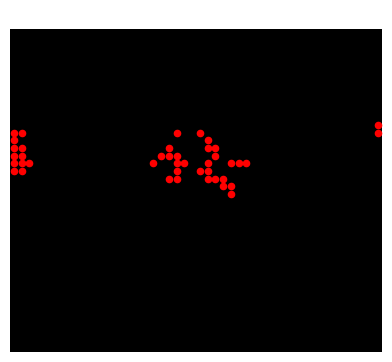

In [21]:
N = 42

tube_qr_dexomposition = TensorTubeQRDecomposition(A_tensor, N)

P, Q, R = tube_qr_dexomposition.factorize()

tube_qr_dexomposition.visualize_sensor_placement()

In [22]:
# Проверка ортогональности Q
Q_T_Q = Q.T @ Q
identity = np.eye(Q.shape[1])
difference = np.linalg.norm(Q_T_Q - identity)

print(f"\nНорма (Q^T Q - I): {difference}")


Норма (Q^T Q - I): 1.7828988077847279e-06


# Formation of dimensions 𝑌


После получения матрицы 𝑃 вы можете сформировать матрицу измерений 𝑌 из исходного тензора 𝑋.

In [25]:
# Загрузка тестовых изображений для конкретного субъекта
test_images = load_images_as_tensor(test_data['Subject_34'])

X_test = test_images[:, :, 1]  # Берем i-е тестовое изображение

# Симуляция измерений
Y_test = P * X_test  # Поэлементное умножение

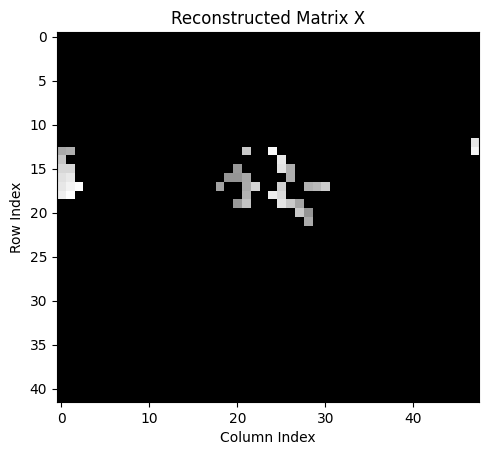

In [40]:
# Plot the reconstructed matrix
plt.imshow(Y_test, cmap='gray')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.title('Reconstructed Matrix X')
plt.show()

In [108]:
# X = tensor['Subject_12'][:,:,43]

# Y = P * X

# # Проверка формы Y
# print(f"Размерность Y: {Y.shape}")

# # Вывод для проверки
# print("Матрица P (расположение сенсоров):")
# print(P)

# print("Результирующая матрица Y:")
# print(Y)

# Tensor compression measurement

Теперь нужно решить оптимизационную задачу для восстановления вектора весов 𝑥, используя измерения 𝑌 и тензор 𝐴.

In [27]:
# def mode_n_product(tensor, matrix, mode):
#     """
#     Computes the mode-n product of a tensor with a matrix along the specified mode.

#     Parameters:
#     - tensor: numpy ndarray of shape (I1, I2, ..., In, ..., IN)
#     - matrix: numpy ndarray of shape (J, In)
#     - mode: int, the mode along which to compute the product (0-based index)

#     Returns:
#     - result_tensor: numpy ndarray of shape (I1, ..., I_{n-1}, J, I_{n+1}, ..., IN)
#     """
#     # Ensure mode is valid
#     N = tensor.ndim
#     if mode < 0 or mode >= N:
#         raise ValueError(f"Mode should be between 0 and {N-1}, got mode={mode}")
    
#     # Move the specified mode to the first dimension
#     tensor_perm = np.moveaxis(tensor, mode, 0)
#     # tensor_perm has shape (In, I1, ..., I_{n-1}, I_{n+1}, ..., IN)
    
#     # Reshape tensor to 2D matrix for multiplication
#     In = tensor_perm.shape[0]
#     remaining_shape = tensor_perm.shape[1:]
#     tensor_mat = tensor_perm.reshape(In, -1)
#     # tensor_mat has shape (In, M), where M is the product of the remaining dimensions
    
#     # Perform matrix multiplication
#     # matrix has shape (J, In)
#     # Resulting matrix will have shape (J, M)
#     result_mat = matrix @ tensor_mat  # Equivalent to np.dot(matrix, tensor_mat)
    
#     # Reshape the result back to tensor form
#     result_shape = (matrix.shape[0],) + remaining_shape
#     result_tensor = result_mat.reshape(result_shape)
#     Z
#     # Move the axes back to the original order, replacing mode dimension with new one
#     result_tensor = np.moveaxis(result_tensor, 0, mode)
    
#     return result_tensor

In [28]:
# def tube_fiber_wise_dot_product(X):
#     """
#     Вычисляет tube fiber-wise dot product тензора X с самим собой.
    
#     Параметры:
#     - X: numpy массив размерности (I, J, K)
    
#     Возвращает:
#     - C: numpy массив размерности (I, J), где C[i, j] = sum_k X[i, j, k]^2
#     """
#     if not isinstance(X, np.ndarray) or X.ndim != 3:
#         raise ValueError("X должен быть 3D numpy массивом.")
#     C = np.sum(X * X, axis=2)  # Суммируем по оси K
    
#     return C

In [29]:
# def mode_3_fiberwise_product(X, B):
#     """
#     Performs the mode-3 fiber-wise product of tensor X with matrix B.
    
#     Parameters:
#     - X: numpy ndarray of shape (I, J, K)
#     - B: numpy ndarray of shape (K, K)
    
#     Returns:
#     - result: numpy ndarray of shape (I, J, K)
#     """
#     I, J, K = X.shape
#     if B.shape != (K, K):
#         raise ValueError(f"Matrix B must have shape ({K}, {K})")
    
#     # Reshape X to (I*J, K)
#     X_reshaped = X.reshape(-1, K)  # Shape: (I*J, K)
    
#     # Perform matrix multiplication for each fiber
#     # Since we need to multiply each vector X_reshaped[n, :] by B,
#     # we can use a single matrix multiplication
#     # Result will be of shape (I*J, K)
#     result_reshaped = X_reshaped @ B.T  # Transpose B to match dimensions
    
#     # Reshape back to (I, J, K)
#     result = result_reshaped.reshape(I, J, K)
    
#     return result


In [30]:
# def frontal_slicewise_product(X, v):
#     """
#     Performs the frontal slice-wise product of tensor X with vector v.
    
#     Parameters:
#     - X: numpy ndarray of shape (I, J, K)
#     - v: numpy ndarray of shape (K,)
    
#     Returns:
#     - result: numpy ndarray of shape (I, J)
#     """
#     I, J, K = X.shape
#     if v.shape[0] != K:
#         raise ValueError(f"Vector v must have length {K}")
    
#     # Initialize result array
#     result = np.zeros((I, J))
    
#     # Perform the operation
#     for k in range(K):
#         result += X[:, :, k] * v[k]
    
#     return result

In [31]:
# def frontal_slicewise_transpose(X):
#     """
#     Performs the frontal slice-wise transpose of tensor X.
    
#     Parameters:
#     - X: numpy ndarray of shape (I, J, K)
    
#     Returns:
#     - result: numpy ndarray of shape (I, J, K)
#     """
#     # Reverse the order of the frontal slices
#     result = X[:, :, ::-1]
#     return result

In [32]:
# def tensor_based_compressive_sensing(
#     A: Union[np.ndarray],
#     P: Union[np.ndarray],
#     Y: Union[np.ndarray],
#     max_iter: int,
#     epsilon: float,
#     lambd: float,
#     delta_0: float,
#     delta_max: float
# ) -> np.ndarray:
#     """
#     Реализует тензорный алгоритм компрессивного измерения.

#     Параметры:
#     - A: Тензор словаря размера (I, J, W)
#     - P: Матрица выбора сенсоров размера (I, J)
#     - Y: Матрица измерений размера (I, J)
#     - max_iter: Максимальное число итераций
#     - epsilon: Пороговое значение для операции мягкого порога
#     - lambd: Регуляризационный параметр λ
#     - delta_0: Начальное значение параметра штрафа δ
#     - delta_max: Максимальное значение для δ

#     Возвращает:
#     - x_hat: Восстановленный разреженный вектор коэффициентов размера (W,)
#     """
#     # Убеждаемся, что входные данные имеют правильный тип
#     A = np.array(A, dtype=np.float64)
#     P = np.array(P, dtype=np.float64)
#     Y = np.array(Y, dtype=np.float64)
    
#     # Размерности
#     I, J, W = A.shape
    
#     # Проверка размерностей матриц P и Y
#     assert P.shape == (I, J), "Размерность матрицы P должна быть (I, J)"
#     assert Y.shape == (I, J), "Размерность матрицы Y должна быть (I, J)"
    
#     # Инициализация переменных
#     x_n = np.zeros((W, 1), dtype=np.float64)
#     d_n = np.zeros((W, 1), dtype=np.float64)
#     p_n = np.zeros((W, 1), dtype=np.float64)
#     delta_n = delta_0
    
#     # Применяем P к A и Y
#     # Расширяем P до размерности (I, J, 1) для поэлементного умножения
#     P_expanded = P[:, :, np.newaxis]  # Размерность (I, J, 1)
    
#     # Применяем маску P к тензору A
#     A_masked = A * P_expanded  # Размерность (I, J, W)
    
#     # Применяем маску P к Y
#     Y_masked = Y * P  # Размерность (I, J)
    
#     # Разворачиваем A_masked и Y_masked
#     A_unfold = A_masked.reshape(-1, W)      # Размерность (I * J, W)
#     Y_unfold = Y_masked.reshape(-1, 1)      # Размерность (I * J, 1)
#     P_vec = P.flatten()                     # Размерность (I * J,)
    
#     # Индексы сенсоров (позиции, где P != 0)
#     sensor_indices = np.where(P_vec != 0)[0]
    
#     # Отбираем строки, соответствующие сенсорам
#     A_sensors = A_unfold[sensor_indices, :]  # Размерность (N, W), N - число сенсоров
#     Y_sensors = Y_unfold[sensor_indices]     # Размерность (N, 1)
    
#     # Предварительные вычисления
#     A_T_A = A_sensors.T @ A_sensors          # Размерность (W, W)
#     A_T_Y = A_sensors.T @ Y_sensors          # Размерность (W, 1)
#     I_W = np.eye(W, dtype=np.float64)        # Единичная матрица (W, W)
    
#     # Итерационный процесс
#     for n in range(max_iter):
#         # Обновление x_n
#         left_matrix = A_T_A + delta_n * I_W  # Размерность (W, W)
#         right_vector = A_T_Y + delta_n * (d_n - p_n)  # Размерность (W, 1)
        
#         # Решаем систему линейных уравнений
#         x_n = np.linalg.solve(left_matrix, right_vector)  # Размерность (W, 1)
        
#         # Обновление x_hat
#         x_hat = lambd * x_n + (1 - lambd) * d_n  # Размерность (W, 1)
        
#         # Обновление d_n с помощью операции мягкого порога
#         temp = x_hat + p_n  # Размерность (W, 1)
#         threshold = epsilon / delta_n
#         d_n = np.sign(temp) * np.maximum(np.abs(temp) - threshold, 0)  # Размерность (W, 1)
        
#         # Обновление p_n
#         p_n += x_hat - d_n  # Размерность (W, 1)
        
#         # Обновление delta_n
#         delta_n = min(delta_n, delta_max)
    
#     # Возвращаем восстановленный вектор коэффициентов
#     return x_hat.flatten()

In [33]:
from TBMD.TensorBasedCompressiveSensing import TensorCompressiveSensing

In [34]:
# Hyperparameters
max_iter = 100
epsilon_cs = 1e-2
lambda_ = 0.95
delta_0 = 0.01
delta_max = 0.01

# Use the class
cs_solver = TensorCompressiveSensing(A_tensor, P, Y_test, max_iter, epsilon_cs, lambda_, delta_0, delta_max)
x_hat = cs_solver.solve()

In [35]:
x_hat

array([ 2.01123209e-01, -1.48933301e-03,  6.67582480e-03, -5.01375639e-02,
        7.60685231e-04, -2.50419407e-03, -3.57227473e-03,  2.78333018e-03,
        1.42187440e-03,  1.03165927e-03,  5.19221755e-04,  2.49944375e-03,
        1.31204228e-03, -3.04847190e-03, -1.04625555e-03, -6.06400915e-04,
       -2.56414463e-03, -2.68818724e-02, -2.35345687e-03,  1.15623835e-03,
        2.47649465e-03, -2.02159906e-03,  1.92099497e-03,  1.13436581e-03,
        4.21899846e-02, -3.42011432e-03, -4.75073943e-04,  1.51566145e-03,
        8.67895899e-04, -5.83267020e-05, -1.15115189e-03,  8.52128431e-04,
        1.56144648e-05, -3.06123006e-04, -1.29465768e-03, -4.70239711e-04,
        6.45601725e-04,  1.21862264e-04,  6.40606299e-04, -7.28166174e-05,
        1.68091085e-04,  3.44733109e-05])

In [36]:
# # Гиперпараметры для компрессивного измерения
# max_iter = 100
# epsilon_cs = 1e-2
# lambda_ = 0.95
# delta_0 = 0.01
# delta_max = 0.01


# x_hat = tensor_based_compressive_sensing(
#     A_tensor, P, Y, max_iter, epsilon_cs, lambda_, delta_0, delta_max
# )

# Field restoration 𝑋

Используя полученный вектор весов 𝑥, мы можем восстановить поле 𝑋.

In [37]:
# Восстанавливаем тензорное поле
# x_hat должен быть размерности (R,)
X_reconstructed = tl.tenalg.mode_dot(A_tensor, x_hat.squeeze(), mode=2)  # Применяем x_hat по третьему измерению

# X_reconstructed будет тензором размерности (I, J)

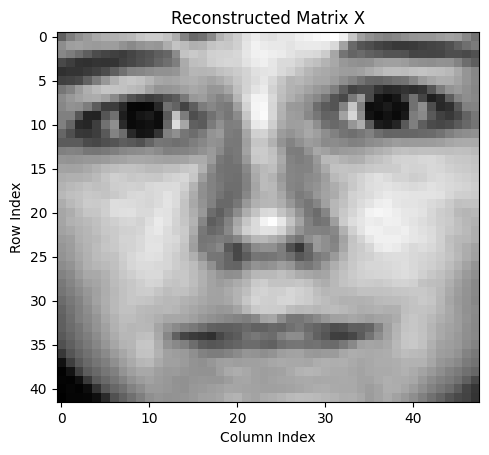

In [38]:
# Plot the reconstructed matrix
plt.imshow(X_reconstructed, cmap='gray')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.title('Reconstructed Matrix X')
plt.show()

In [39]:
error = tl.norm(X_test - X_reconstructed) / tl.norm(X_test)
print(f"Ошибка восстановления для тестового изображения: {error}")

Ошибка восстановления для тестового изображения: 0.11725841054763526
